<a href="https://colab.research.google.com/github/hyunseo318/Style-Week/blob/main/epick_editor_recommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# install DGL in Colab
!pip install dgl -f https://data.dgl.ai/wheels/repo.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.dgl.ai/wheels/repo.html
     |████████████████████████████████| 4.9 MB 6.7 MB/s 
     |████████████████████████████████| 280 kB 4.1 MB/s 
  Attempting uninstall: psutil
    Found existing installation: psutil 5.4.8
    Uninstalling psutil-5.4.8:
      Successfully uninstalled psutil-5.4.8


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import itertools
import numpy as np
import scipy.sparse as sp
import dgl
import pandas as pd

DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


In [ ]:
node_df = pd.read_csv('/content/drive/MyDrive/Style_Week/styleweek_epick_node.csv')
edge_df = pd.read_csv('/content/drive/MyDrive/Style_Week/styleweek_epick_edge.csv')

In [ ]:
# node_df.drop_duplicates(subset=['profile_id'], keep='first', inplace=True)
# node_df.reset_index(drop=True, inplace=True)
# edge_df.drop_duplicates(keep='first', inplace=True)
# edge_df.reset_index(drop=True, inplace=True)

In [ ]:
node_to_idx = {}
for idx, row in node_df.iterrows():
  node_to_idx[row['profile_id']] = {
      'idx': idx,
      'user_account_id': row['user_account_id'],
      'age': row['age']
}

In [ ]:
idx_to_node = {}
for idx, row in node_df.iterrows():
  idx_to_node[idx] = {
      'profile_id': row['profile_id'],
      'user_account_id': row['user_account_id'],
      'age': row['age']
}

In [ ]:
age_onehot = {
    0: '1 0 0 0 0 0 0',
    10: '0 1 0 0 0 0 0',
    20: '0 0 1 0 0 0 0',
    30: '0 0 0 1 0 0 0',
    40: '0 0 0 0 1 0 0',
    50: '0 0 0 0 0 1 0',
    60: '0 0 0 0 0 0 1'
}

In [ ]:
profile_id = []
age = []
for idx, row in node_df.iterrows():
  profile_id.append(node_to_idx[row['profile_id']]['idx'])
  age.append(age_onehot[row['age']])

In [ ]:
node_list = [profile_id, age]

le_node_df = pd.DataFrame (node_list).transpose()
le_node_df.columns = ['profile_id', 'age']

In [ ]:
from_profile_id = []
to_profile_id = []
for idx, row in edge_df.iterrows():
  from_profile_id.append(node_to_idx[row['from_profile_id']]['idx'])
  to_profile_id.append(node_to_idx[row['to_profile_id']]['idx'])

In [ ]:
edge_list = [from_profile_id, to_profile_id]

le_edge_df = pd.DataFrame (edge_list).transpose()
le_edge_df.columns = ['from_profile_id', 'to_profile_id']

In [ ]:
le_edge_df.to_csv('/content/drive/MyDrive/Style_Week/le_edge.csv', index=False, header=None)
le_node_df.to_csv('/content/drive/MyDrive/Style_Week/le_node.csv', index=False, header=None)

In [ ]:
live_editor = {}
with open('/content/drive/MyDrive/Style_Week/styleweek_live_editor.csv') as f:  # load edges file
    for idx, line in enumerate(f):
        if idx == 0:
            continue
        row = line.split(',')
        live_editor[int(row[0])] = int(row[1].replace('\n', ''))

In [ ]:
u, v = [], []

with open('/content/drive/MyDrive/Style_Week/le_edge.csv') as f:  # load edges file
    for line in f:
        e1, e2 = tuple(int(x) for x in line.split(','))
        u.append(e1)
        v.append(e2)

u, v = np.array(u), np.array(v)

In [ ]:
num_nodes = 0  # assumes nodes are sequential
feats = []  # node features

with open('/content/drive/MyDrive/Style_Week/le_node.csv') as f:  # load node features file
    for line in f:
      num_nodes += 1
      onehot = line[:-1].split(',')[1].split()
      onehot = list(map(int, onehot))
      feats.append(torch.tensor(onehot, dtype=torch.float))

feats = torch.stack(feats)

g = dgl.graph((u, v))  # construct graph
g.ndata['feat'] = feats

In [ ]:
g

Graph(num_nodes=12683, num_edges=74120,
      ndata_schemes={'feat': Scheme(shape=(7,), dtype=torch.float32)}
      edata_schemes={})

In [ ]:
!pip install networkx

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# import networkx as nx
# import matplotlib.pyplot as plt

# G = nx.Graph()
# G.add_nodes_from(set(u + v))
# G.add_edges_from(zip(u, v))

# plt.figure(4, figsize=(14,14)) 
# nx.draw(G, node_size=0)
# plt.show()

In [ ]:
num_nodes

12683

In [ ]:
TEST_RATIO = 0.2  # ratio for splitting the test set

u, v = g.edges()

eids = np.arange(g.number_of_edges())
eids = np.random.permutation(eids)
test_size = int(len(eids) * TEST_RATIO)  # number of edges in test set
train_size = g.number_of_edges() - test_size  # number of edges in train set

# get positive edges for test and train
test_pos_u, test_pos_v = u[eids[:test_size]], v[eids[:test_size]]
train_pos_u, train_pos_v = u[eids[test_size:]], v[eids[test_size:]]

# Find all negative edges
adj = sp.coo_matrix((np.ones(len(u)), (u.numpy(), v.numpy())), shape=(12683, 12683))
adj_neg = 1 - adj.todense() - np.eye(g.number_of_nodes())
neg_u, neg_v = np.where(adj_neg != 0)

# split the negative edges for training and testing 
neg_eids = np.random.choice(len(neg_u), g.number_of_edges())
test_neg_u, test_neg_v = neg_u[neg_eids[:test_size]], neg_v[neg_eids[:test_size]]
train_neg_u, train_neg_v = neg_u[neg_eids[test_size:]], neg_v[neg_eids[test_size:]]

# construct positive and negative graphs for training and testing
train_pos_g = dgl.graph((train_pos_u, train_pos_v), num_nodes=g.number_of_nodes())
train_neg_g = dgl.graph((train_neg_u, train_neg_v), num_nodes=g.number_of_nodes())

test_pos_g = dgl.graph((test_pos_u, test_pos_v), num_nodes=g.number_of_nodes())
test_neg_g = dgl.graph((test_neg_u, test_neg_v), num_nodes=g.number_of_nodes())

# training graph
train_g = dgl.remove_edges(g, eids[:test_size])
train_g = dgl.add_self_loop(train_g)

In [ ]:
from dgl.nn import SAGEConv
from dgl.nn import GraphConv

# ----------- create model -------------- #
# build an ordinary GCN model
class GCN(nn.Module):
    def __init__(self, in_feats, h_feats):
        super(GCN, self).__init__()
        self.conv1 = GraphConv(in_feats, h_feats)
        self.conv2 = GraphConv(h_feats, h_feats)

    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = F.relu(h)
        h = self.conv2(g, h)
        return h


# build a two-layer GraphSAGE model
class GraphSAGE(nn.Module):
    def __init__(self, in_feats, h_feats):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_feats, h_feats, 'mean')
        self.conv2 = SAGEConv(h_feats, h_feats, 'mean')

    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = F.relu(h)
        h = self.conv2(g, h)
        return h


import dgl.function as fn

class DotPredictor(nn.Module):
    def forward(self, g, h):
        with g.local_scope():
            g.ndata['h'] = h
            # Compute a new edge feature named 'score' by a dot-product between the
            # source node feature 'h' and destination node feature 'h'.
            g.apply_edges(fn.u_dot_v('h', 'h', 'score'))
            # u_dot_v returns a 1-element vector for each edge so you need to squeeze it.
            return g.edata['score'][:, 0]


In [ ]:
def pipeline(model_name='GCN', hidden_size=16):
    # model_name can be GCN or SAGE
    # hidden_size is the size of the hidden layer in the neural net
    if model_name == 'GCN':
        model = GCN(train_g.ndata['feat'].shape[1], hidden_size)
    elif model_name == 'SAGE':
        model = GraphSAGE(train_g.ndata['feat'].shape[1], hidden_size)
        
    pred = DotPredictor()

    def compute_loss(pos_score, neg_score):  # computes the loss based on binary cross entropy
        scores = torch.cat([pos_score, neg_score])
        labels = torch.cat([torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])])
        return F.binary_cross_entropy_with_logits(scores, labels)

    def compute_auc(pos_score, neg_score):  # computes AUC (Area-Under-Curve) score
        scores = torch.cat([pos_score, neg_score]).numpy()
        labels = torch.cat(
            [torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])]).numpy()
        return roc_auc_score(labels, scores)


    # ----------- set up loss and optimizer -------------- #
    # in this case, loss will in training loop
    optimizer = torch.optim.Adam(itertools.chain(model.parameters(), pred.parameters()), lr=0.01)

    # ----------- training -------------------------------- #
    all_logits = []
    for e in range(300):
        # forward
        h = model(train_g, train_g.ndata['feat'])  # get node embeddings
        pos_score = pred(train_pos_g, h)
        neg_score = pred(train_neg_g, h)
        loss = compute_loss(pos_score, neg_score)

        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if e % 5 == 0:
            print(f'{e},{loss}')

    # ----------- test and check results ---------------- #
    from sklearn.metrics import roc_auc_score
    with torch.no_grad():
        pos_score = pred(test_pos_g, h)
        neg_score = pred(test_neg_g, h)
        print('AUC', compute_auc(pos_score, neg_score))
    
    return h  # return node embeddings


In [ ]:
h = pipeline("GCN")

0,0.5778982639312744
5,0.493759423494339
10,0.49028918147087097
15,0.48607325553894043
20,0.4837704598903656
25,0.48188066482543945
30,0.4804133474826813
35,0.4801752269268036
40,0.47900819778442383
45,0.4789379835128784
50,0.47832784056663513
55,0.47802790999412537
60,0.4777248501777649
65,0.47734150290489197
70,0.47707244753837585
75,0.47683483362197876
80,0.4765627682209015
85,0.47623154520988464
90,0.47569647431373596
95,0.47443583607673645
100,0.4732246398925781
105,0.4722675085067749
110,0.4706793427467346
115,0.46883755922317505
120,0.4665389955043793
125,0.4638329744338989
130,0.4607032537460327
135,0.45722079277038574
140,0.4533700942993164
145,0.44966620206832886
150,0.44634783267974854
155,0.443644642829895
160,0.4417833089828491
165,0.44074198603630066
170,0.44030576944351196
175,0.4400344789028168
180,0.43985095620155334
185,0.4396888315677643
190,0.4395139217376709
195,0.43935173749923706
200,0.43920621275901794
205,0.4390580952167511
210,0.43891778588294983
215,0.4387613

In [ ]:
h = pipeline("SAGE")

0,1.4096324443817139
5,0.729232907295227
10,0.6928471326828003
15,0.6818873286247253
20,0.6675664782524109
25,0.6545252203941345
30,0.6397343277931213
35,0.6249663233757019
40,0.6091164350509644
45,0.5937596559524536
50,0.5805569291114807
55,0.5682660937309265
60,0.5572195649147034
65,0.5475687980651855
70,0.539520800113678
75,0.5327664017677307
80,0.5274065136909485
85,0.5229986310005188
90,0.5193445086479187
95,0.5162317752838135
100,0.5140976309776306
105,0.5119513869285583
110,0.5099738240242004
115,0.5082497000694275
120,0.5067933201789856
125,0.5056087374687195
130,0.5042562484741211
135,0.5033745765686035
140,0.5020501017570496
145,0.5015342831611633
150,0.5002395510673523
155,0.4999537467956543
160,0.49897825717926025
165,0.4979296326637268
170,0.4973450303077698
175,0.49670302867889404
180,0.4960085451602936
185,0.4954429268836975
190,0.4946777820587158
195,0.49409741163253784
200,0.493495911359787
205,0.4928859770298004
210,0.4922723174095154
215,0.4917011559009552
220,0.4911

In [ ]:
# --------- generate recommendation for user -------- #
def generate_rec(h, profile_label=0, k=50):
    # `h` represents the node embeddings, with shape [num_nodes, hidden_size]

    # generate a graph with (num_nodes - num_friends_of_user) edges
    # one end of the edge is profile_id
    # the other end is a user that's NOT friends with profile_id
    user_friends = set()
    user_neg_u, user_neg_v = [], []
    for n1, n2 in zip(u, v):   # get all friends of profile_id
        if int(n1) == profile_label:
            user_friends.add(int(n2))
        if int(n2) == profile_label:
            user_friends.add(int(n1))

    for i in range(num_nodes):  # generate "negative edges" for profile_id
        if i != profile_label and i not in user_friends:
            user_neg_u.append(profile_label)
            user_neg_v.append(i)
            
    user_g = dgl.graph((user_neg_u, user_neg_v), num_nodes=g.number_of_nodes())

    pred = DotPredictor()

    # calculate the score of each user
    scores = [(i, score) for i, score in enumerate(pred(user_g, h))]

    # produce final ranked list
    scores.sort(key=lambda x: -x[1])

    # display results
    print(f"List of suggested friends for profile_label {profile_label}:")
    for i in range(k):
        candidate = live_editor.get(idx_to_node[scores[i][0]]['profile_id'])
        if candidate:
            print(f"- profile_label {scores[i][0]}, profile_id {idx_to_node[scores[i][0]]['profile_id']}, score = {round(float(scores[i][1]), 4)}")
        else:
            pass


In [ ]:
generate_rec(h, profile_label=14, k=100)

List of suggested friends for profile_label 14:
- profile_label 8412, profile_id 1285573, score = 2.3741
- profile_label 8078, profile_id 1114, score = 2.32
- profile_label 2816, profile_id 1018, score = 2.0391
- profile_label 8084, profile_id 765, score = 2.0304
- profile_label 4577, profile_id 678014, score = 2.0132
- profile_label 1763, profile_id 801, score = 1.9104
- profile_label 6685, profile_id 778, score = 1.855
- profile_label 6363, profile_id 868861, score = 1.847
- profile_label 5318, profile_id 354457, score = 1.8236
- profile_label 7371, profile_id 833082, score = 1.8236
- profile_label 9853, profile_id 1034, score = 1.8236
- profile_label 1045, profile_id 810, score = 1.8117
- profile_label 11653, profile_id 908, score = 1.8043
- profile_label 2455, profile_id 504658, score = 1.7952
- profile_label 3890, profile_id 977, score = 1.7921
- profile_label 2858, profile_id 917, score = 1.791
- profile_label 4240, profile_id 950, score = 1.7652
- profile_label 2454, profile_id 

In [ ]:
idx_to_node[8412]

{'profile_id': 1285573, 'user_account_id': 824639, 'age': 20}

In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

tsne_np = TSNE(n_components = 3).fit_transform(h.cpu().detach().numpy())

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [ ]:
tsne_df = pd.DataFrame(tsne_np, columns = ['component 0', 'component 1', 'component 2'])

In [ ]:
tsne_df['target'] = node_df['age']

In [ ]:
def remove_max_outlier(dataset, col):
    q1 = dataset[col].quantile(0.25)
    q2 = dataset[col].quantile(0.5)
    q3 = dataset[col].quantile(0.75)
    iqr = q3 - q1

    condition = dataset[col] > q3 + 1.5 * iqr
    dataset[condition]
    
    idx = dataset[condition].index
    dataset.drop(idx, inplace=True)
    dataset.reset_index(drop=True, inplace=True)
    
    return dataset

In [ ]:
def remove_min_outlier(dataset, col):
    q1 = dataset[col].quantile(0.25)
    q2 = dataset[col].quantile(0.5)
    q3 = dataset[col].quantile(0.75)
    iqr = q3 - q1

    condition = dataset[col] < q1 - 1.5 * iqr
    dataset[condition]
    
    idx = dataset[condition].index
    dataset.drop(idx, inplace=True)
    dataset.reset_index(drop=True, inplace=True)
    
    return dataset

In [ ]:
tsne_df = remove_max_outlier(tsne_df, 'component 0')
tsne_df = remove_max_outlier(tsne_df, 'component 1')
tsne_df = remove_max_outlier(tsne_df, 'component 2')

In [ ]:
tsne_df = remove_min_outlier(tsne_df, 'component 0')
tsne_df = remove_min_outlier(tsne_df, 'component 1')
tsne_df = remove_min_outlier(tsne_df, 'component 2')

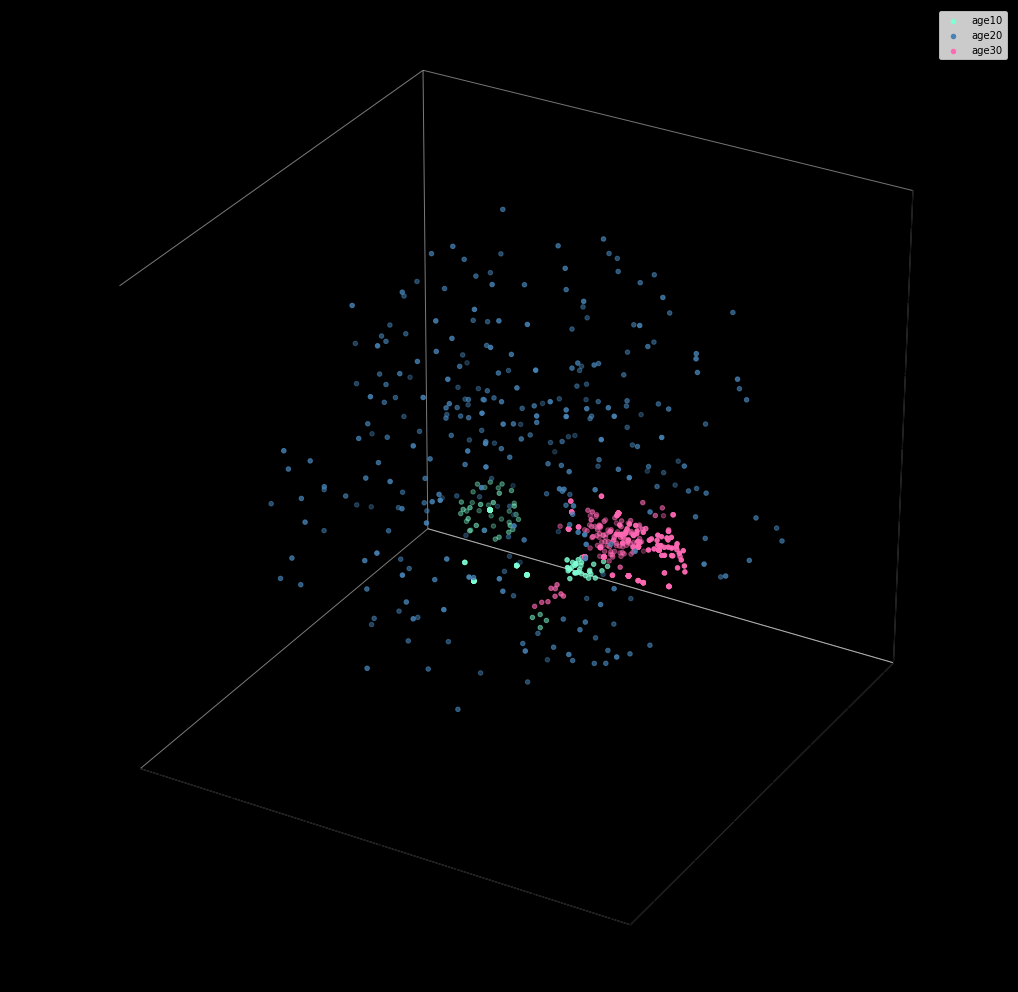

<Figure size 432x288 with 0 Axes>

In [ ]:
# 3차원 그래프 세팅
fig = plt.figure(figsize=(18, 18))
ax = plt.axes(projection='3d')

# target 별 분리
tsne_df_0 = tsne_df[tsne_df['target'] == 10][:1000]
tsne_df_1 = tsne_df[tsne_df['target'] == 20][:300]
tsne_df_2 = tsne_df[tsne_df['target'] == 30][:1000]

# target 별 시각화
ax.scatter(tsne_df_0['component 0'], tsne_df_0['component 1'], tsne_df_0['component 2'], color = 'aquamarine', label = 'age10')
ax.scatter(tsne_df_1['component 0'], tsne_df_1['component 1'], tsne_df_1['component 2'], color = 'steelblue', label = 'age20')
ax.scatter(tsne_df_2['component 0'], tsne_df_2['component 1'], tsne_df_2['component 2'], color = 'hotpink', label = 'age30')

fig.set_facecolor('black')
ax.set_facecolor('black') 
ax.grid(False) 
ax.w_xaxis.pane.fill = False
ax.w_yaxis.pane.fill = False
ax.w_zaxis.pane.fill = False

ax.set_xlabel('component 0')
ax.set_ylabel('component 1')
ax.set_zlabel('component 2')
ax.legend()
plt.show()
plt.savefig('/content/drive/MyDrive/Style_Week/tsne.jpg')

In [ ]:
# Graph visualization

from pyvis.network import Network

net= Network(notebook=True, bgcolor='#000000') # 백그라운드 색 설정 

from_id = list(follows_check['from_profile_id'])
to_id = list(follows_check['to_profile_id'])

edges = []
for i in range(len(follows_check)):
    from_check = from_id[i]
    to_check = to_id[i]

    if to_check in to_profile_dict: # 팔로워 수에 따른 색깔 변경 
        color = to_profile_dict[to_check] # dict에서 value (= 팔로워 수)
        
        if color >= 20:
            net.add_node(to_check, label=to_id, size=70, color='#fe9923')
        elif color >=10:
            net.add_node(to_check, label=to_id, size=60, color='#ffa943')
        elif color >=5:
            net.add_node(to_check, label=to_id, size=40, color='#ffcd40')
        elif color >=3:
            net.add_node(to_check, label=to_id, color='#fed42d')
        else:
            net.add_node(to_check, label=to_id, color='#fff066')
    
    pair = (from_check, to_check)
    edges.append(pair)
    
    net.add_node(from_check, label=from_id, color='fff066')

net.add_edges(edges)

net.toggle_physics(True)
net.show('nodes.html')